In [1]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [61]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt

# Connect to SQLite database
db_path = "employee_management0.db"  # Change to your DB file
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

**Access Schema and extract table names**

In [64]:
def get_schema(db_path="employee_management0.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    schema = {}
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()
    
    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = [row[1] for row in cursor.fetchall()]
        schema[table_name] = columns
    
    conn.close()
    return schema

In [65]:
schema = get_schema()

**Access Schema and extract edges(Foreign keys)**

In [66]:
# Extract edges from foreign key constraints
# Using attention mechanism to assign higher weights to strong relationships

def get_edges(db_path="employee_management0.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    table_indices = {table: idx for idx, table in enumerate(schema.keys())}
    edges = []
    edge_weights = []
    
    for table in schema.keys():
        cursor.execute(f"PRAGMA foreign_key_list({table})")
        fks = cursor.fetchall()
        for fk in fks:
            ref_table = fk[2]
            if ref_table in table_indices:
                edges.append((table_indices[table], table_indices[ref_table]))  # FK connection
                edges.append((table_indices[ref_table], table_indices[table]))
                edge_weights.extend([2.0, 2.0])  # Higher weight for strong relationships
    
    conn.close()
    return edges, edge_weights

In [67]:
edges, edge_weights = get_edges()

In [68]:
edges

[(1, 0),
 (0, 1),
 (2, 0),
 (0, 2),
 (3, 0),
 (0, 3),
 (4, 0),
 (0, 4),
 (5, 0),
 (0, 5),
 (6, 5),
 (5, 6),
 (6, 1),
 (1, 6)]

In [69]:
edge_weights

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

In [70]:
import torch
# Detect GPU if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)
edge_weights = torch.tensor(edge_weights, dtype=torch.float).to(device)

**Visual Representation of Schema in Graph**

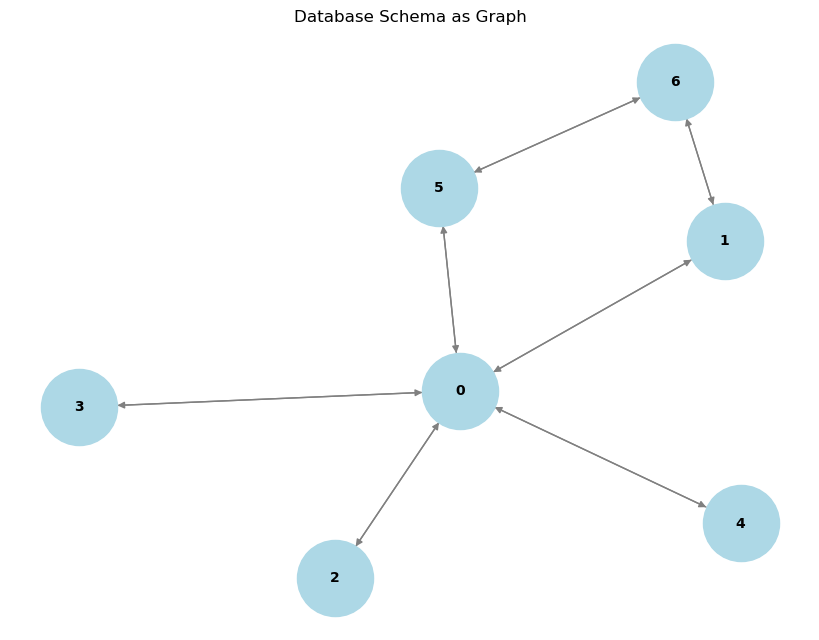

In [50]:
G = nx.DiGraph()
G.add_nodes_from(tables)
G.add_edges_from(edges)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold')
plt.title("Database Schema as Graph")
plt.show()

In [18]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install sentence_transformers


  Using cached sentence_transformers-3.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
Using cached sentence_transformers-3.4.1-py3-none-any.whl (275 kB)
Using cached huggingface_hub-0.29.3-py3-none-any.whl (468 kB)
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ------------- -------------------------- 3.4/10.2 MB 20.0 MB/s eta 0:00:01
   -------------------------------- ------- 8.4/10.2 MB 21.7 MB/s eta 0:00:01
   ---------------------------------------  10.0/10.2 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------  10.0/10.2 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------- 10.2/10.2 MB 11.1 MB/s eta 0:00:00
Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl (308 kB)
Using cached tokenizers-0.21.1-cp39-abi3-win

In [ ]:
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv # For Graph Convolutional Networks
from functools import lru_cache
from sentence_transformers import SentenceTransformer # For prompt embeddings

In [73]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

In [74]:
@lru_cache(maxsize=500)
def encode_text(text):
    return sentence_model.encode(text, convert_to_tensor=True, show_progress_bar=False).to(device)

In [75]:
table_embeddings = {
    table: encode_text(table + " " + " ".join(schema[table]) + " " + " ".join([f"{col}:{table}" for col in schema[table]])) 
    for table in schema.keys()
}


In [ ]:
table_names = list(schema.keys()) # extract table names
table_features = torch.stack([table_embeddings[table] for table in table_names]).to(device) # stack table embeddings

In [77]:
table_names

['Employees',
 'Departments',
 'Positions',
 'Salaries',
 'Benefits',
 'Projects',
 'Clients']

In [78]:
table_features

tensor([[-0.0857,  0.0031, -0.0017,  ...,  0.0759,  0.0812,  0.0580],
        [-0.0121, -0.0254,  0.0146,  ...,  0.0501,  0.0601,  0.0289],
        [-0.0011,  0.0581, -0.0478,  ..., -0.0079,  0.0382,  0.0968],
        ...,
        [-0.0435,  0.0859,  0.0298,  ...,  0.0734,  0.0539,  0.0588],
        [-0.0033,  0.0651, -0.0493,  ...,  0.0210, -0.0130,  0.0527],
        [-0.0145,  0.0323, -0.0312,  ...,  0.0843, -0.0037,  0.0502]])

**GCN Model building**

In [ ]:
# Learning embeddings for database tables based on their connections (foreign keys).
# Propagates information across the database schema graph

In [ ]:
class GCN_TABLE_ENCODER(torch.nn.Module): # from Pytorch Neural network module
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TableEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim) # 1st GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim) # 2nd GCN layer and final layer
        #input_dim = table embedding
        #hidden_dim = intermediate layer
        # output_dim = final embedding for each table        
    def forward(self, x, edge_index, edge_weight=None): # data flow
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training) # dropping down 20% of the neurons to avoid overfitting
        x = self.conv2(x, edge_index, edge_weight) # final layer refines the table embeddings based on graph connections.
        return x
        # x node features (table embeddings)
        # edge_index = graph structure (table connectivity via foreign keys)
        # edge_weight = attention weights for each edge

In [ ]:
class QueryTableMatcher(torch.nn.Module):
    def __init__(self, query_dim, table_dim, hidden_dim, output_dim):
        super(QueryTableMatcher, self).__init__()
        self.query_encoder = torch.nn.Sequential(
            torch.nn.Linear(query_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.table_encoder = GCN_TABLE_ENCODER(table_dim, hidden_dim, hidden_dim)
        self.attention = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, query_emb, table_feats, edge_index, edge_weight=None):
        query_hidden = self.query_encoder(query_emb)
        table_hidden = self.table_encoder(table_feats, edge_index, edge_weight)
        
        query_attn = self.attention(query_hidden).unsqueeze(1)
        table_hidden_t = table_hidden.unsqueeze(0).repeat(query_emb.size(0), 1, 1)
        
        scores = torch.bmm(query_attn, table_hidden_t.transpose(1, 2)).squeeze(1)
        return torch.sigmoid(scores)

In [ ]:
# Training data
query_table_mapping = [
    ("Retrieve all employee names and their IDs", ["Employees"]),
    ("List all department names and their IDs", ["Departments"]),
    ("Show all positions and their respective titles", ["Positions"]),
    ("Get the salary details of each employee", ["Salaries", "Employees"]),
    ("Find all employees and their respective departments", ["Employees", "Departments"]),
    ("List employees along with their positions", ["Employees", "Positions"]),
    ("Retrieve salary amount and pay date for each employee", ["Salaries", "Employees"]),
    ("Get details of employee benefits", ["Benefits", "Employees"]),
    ("Show all employees assigned to different projects", ["Employees", "Projects"]),
    ("Find all clients along with their associated projects", ["Clients", "Projects"]),
    ("Get the names of all clients and their associated department IDs", ["Clients", "Departments"]),
    ("List all employees who have benefits along with benefit type", ["Employees", "Benefits"]),
    ("Find the total budget allocated for each project", ["Projects"]),
    ("Retrieve project names along with the employees working on them", ["Projects", "Employees"]),
    ("Get client names and the projects they are linked to", ["Clients", "Projects"]),
    ("List all departments and the employees working in them", ["Departments", "Employees"]),
    ("Find out which department a specific client is associated with", ["Clients", "Departments"]),
    ("Get all employees along with their salaries and pay dates", ["Employees", "Salaries"]),
    ("Show all employees and their assigned projects", ["Employees", "Projects"]),
    ("Find employees who are receiving benefits along with benefit details", ["Employees", "Benefits"]),
    ("Get employees' salaries along with their positions", ["Employees", "Salaries", "Positions"]),
    ("Show all projects along with the department they belong to", ["Projects", "Departments"]),
    ("Retrieve all employees and their respective salary amounts", ["Employees", "Salaries"]),
    ("Get all clients along with their associated projects and departments", ["Clients", "Projects", "Departments"]),
    ("Retrieve all employees along with their department and position details", ["Employees", "Departments", "Positions"]),
    ("Get a list of employees with their salaries and the projects they are working on", ["Employees", "Salaries", "Projects"]),
    ("List all employees along with their assigned projects and associated clients", ["Employees", "Projects", "Clients"]),
    ("Show all employees, their benefits, and their assigned departments", ["Employees", "Benefits", "Departments"]),
    ("Find all employees along with their department, salary, and pay date", ["Employees", "Departments", "Salaries"]),
    ("Retrieve project names, the employees working on them, and their respective departments", ["Projects", "Employees", "Departments"]),
    ("List all positions along with employees holding them and their salary details", ["Positions", "Employees", "Salaries"]),
    #("Get all employees who have benefits, their salary details, and their department", ["Employees", "Benefits", "Departments", "Salaries"]),
    ("Show all projects along with their budgets and the employees assigned to them", ["Projects", "Employees", "Salaries"]),
    ("Retrieve clients along with their associated projects and the employees working on those projects", ["Clients", "Projects", "Employees"]),
    #("Find all employees along with their assigned department, projects, and salaries", ["Employees", "Departments", "Projects", "Salaries"]),
    ("List all clients along with the projects they are funding and the employees working on those projects", ["Clients", "Projects", "Employees"]),
    #("Get details of employees who have benefits along with their salaries and project assignments", ["Employees", "Benefits", "Salaries", "Projects"]),
    #("Retrieve all projects along with their assigned employees, department, and clients", ["Projects", "Employees", "Departments", "Clients"]),
    #("Find employees working on projects along with their department and assigned salary details", ["Employees", "Projects", "Departments", "Salaries"]),
    ("List down all employees, their positions, and the benefits they receive", ["Employees", "Positions", "Benefits"]),
    ("Retrieve employees along with their associated clients through project assignments", ["Employees", "Projects", "Clients"]),
    ("Find the departments, projects, and clients associated with each employee", ["Departments", "Projects", "Clients", "Employees"]),
    ("Get all projects along with their allocated budget, department, and assigned employees", ["Projects", "Departments", "Employees"]),
    ("Retrieve clients, their associated departments, and the employees handling their projects", ["Clients", "Departments", "Employees"]),
    ("Show all departments along with their employees and the benefits those employees receive", ["Departments", "Employees", "Benefits"]),
    ("List all employees and their complete salary history, including pay dates", ["Employees", "Salaries"]),
    #("Retrieve all projects with employees assigned, their department, and respective salaries", ["Projects", "Employees", "Departments", "Salaries"]),
    #("Get all employees with their assigned clients, salary details, and department", ["Employees", "Clients", "Salaries", "Departments"]),
    ("Find all clients with their associated projects and the budget allocated for those projects", ["Clients", "Projects"]),
    #("Show employees along with their department, salary, and the clients they interact with", ["Employees", "Departments", "Salaries", "Clients"]),
    #("Retrieve employees and their salary details along with the projects they are working on", ["Employees", "Salaries", "Projects"]),
    #("Find projects along with their department, clients funding them, and assigned employees", ["Projects", "Departments", "Clients", "Employees"]),
    ("Get details of employees working under different departments and handling multiple projects", ["Employees", "Departments", "Projects"]),
    ("List all employees along with their salaries, positions, and associated clients", ["Employees", "Salaries", "Positions", "Clients"]),
    ("Show all projects with their respective budget allocations, departments, and assigned employees", ["Projects", "Departments", "Employees"]),
    ("Retrieve employees, their salaries, and the clients they have worked with through different projects", ["Employees", "Salaries", "Clients"]),
    #("Find employees, their department, and the benefits they receive under specific projects", ["Employees", "Departments", "Benefits", "Projects"]),
    ("List down all employees, their salaries, and the clients they have interacted with", ["Employees", "Salaries", "Clients"]),
    #("Get all employees and their respective department, project assignments, and salaries", ["Employees", "Departments", "Projects", "Salaries"]),
    ("Retrieve all departments, their associated employees, and the projects being handled by them", ["Departments", "Employees", "Projects"]),
    ("Find all projects, their allocated budgets, and the employees assigned to them along with their department", ["Projects", "Employees", "Departments"]),
    ("List all clients along with the projects they are funding and the employees handling those projects", ["Clients", "Projects", "Employees"]),
    #("Retrieve employees and their salary details along with the projects they are handling and their positions", ["Employees", "Salaries", "Projects", "Positions"]),
    #("Get all employees, their department, assigned projects, and the clients they work with", ["Employees", "Departments", "Projects", "Clients"]),
    ("Show projects with their allocated budgets, the clients funding them, and the employees working on them", ["Projects", "Clients", "Employees"]),
    #("Find employees along with their salaries and the projects they are working on in different departments", ["Employees", "Salaries", "Projects", "Departments"]),
    #("Retrieve employees, their departments, and their respective positions along with their salary details", ["Employees", "Departments", "Positions", "Salaries"]),
    #("List down employees, their department, project assignments, and the clients they interact with", ["Employees", "Departments", "Projects", "Clients"]),
    #("Get details of employees working on different projects, their salaries, and department details", ["Employees", "Projects", "Salaries", "Departments"]),
    #("Retrieve all employees with their associated benefits, salaries, and project assignments", ["Employees", "Benefits", "Salaries", "Projects"]),
    #("List all projects, their allocated budgets, the departments handling them, and assigned employees", ["Projects", "Departments", "Employees"]),
    #("Find employees who have worked with multiple clients, their salary details, and department", ["Employees", "Clients", "Salaries", "Departments"]),
    ("Retrieve all employee names", ["Employees"]),
    ("List all department names", ["Departments"]),
    ("Get all position titles", ["Positions"]),
    ("Show all salaries and pay dates", ["Salaries"]),
    ("Find all employee benefits", ["Benefits"]),
    ("List all projects", ["Projects"]),
    ("Retrieve all client names", ["Clients"]),
    ("Find all employee IDs", ["Employees"]),
    ("Show all salary amounts", ["Salaries"]),
    ("Get a list of project budgets", ["Projects"]),
    ("Retrieve all department IDs", ["Departments"]),
    ("Show all project names", ["Projects"]),
    ("Find all positions and their IDs", ["Positions"]),
    ("Get all benefit types available", ["Benefits"]),
    ("Show all clients and their IDs", ["Clients"]),
    ("Retrieve all employees hired before a certain date", ["Employees"]),
    ("List all salaries above a specific amount", ["Salaries"]),
    ("Find all projects with a budget greater than 50,000", ["Projects"]),
    ("Get all employees who receive benefits", ["Employees"]),
    ("Retrieve all positions with a salary grade", ["Positions"]),
    ("Retrieve all employees along with their department names", ["Employees", "Departments"]),
    ("Get all employees and their assigned positions", ["Employees", "Positions"]),
    ("Find all employees along with their salaries and pay dates", ["Employees", "Salaries"]),
    ("Show employees and the projects they are assigned to", ["Employees", "Projects"]),
    ("List all departments and the employees working in them", ["Departments", "Employees"]),
    ("Retrieve projects and the employees working on them", ["Projects", "Employees"]),
    ("Find clients and their associated projects", ["Clients", "Projects"]),
    ("Get employees and their assigned benefits", ["Employees", "Benefits"]),
    ("Show employees and the departments they belong to", ["Employees", "Departments"]),
    ("Retrieve all employees and their assigned projects along with project budgets", ["Employees", "Projects"]),
    ("Find employees who have salaries and benefits", ["Employees", "Salaries", "Benefits"]),
    ("List all positions along with the employees holding them", ["Positions", "Employees"]),
    ("Get projects, their budgets, and assigned employees", ["Projects", "Employees", "Salaries"]),
    ("Retrieve all clients along with their projects and departments", ["Clients", "Projects", "Departments"]),
    ("Find employees who have received benefits and their department", ["Employees", "Benefits", "Departments"]),
    ("Show clients, their associated projects, and employees assigned to those projects", ["Clients", "Projects", "Employees"]),
    ("Retrieve all employees, their salaries, and their positions", ["Employees", "Salaries", "Positions"]),
    ("List employees and the clients they interact with", ["Employees", "Clients"]),
    ("Get projects along with the employees working on them and their salaries", ["Projects", "Employees", "Salaries"]),
    ("Find employees, their departments, and their benefits", ["Employees", "Departments", "Benefits"]),
    ("Find the weather forecast for tomorrow", []),
    ("Retrieve a list of available car rentals", []),
    ("Show me the latest stock market trends", []),
    ("Find the nearest hospitals", []),
    ("Get the latest news headlines", []),
    ("Show me the best restaurants in town", []),
    ("Retrieve football match results", []),
    ("Find the top 10 best-selling books", []),
    ("List all flight schedules from New York to London", []),
    ("Get today's exchange rate for USD to EUR", []),
    ("Retrieve customer reviews for iPhone 15", []),
    ("Find the best hiking trails near me", []),
    ("Show me the top trending movies", []),
    ("List all upcoming concerts in my city", []),
    ("Get a history of Bitcoin prices", []),
    ("Find the current fuel prices", []),
    ("Retrieve the warranty status of my laptop", []),
    ("Get step-by-step cooking recipes", []),
    ("Find out the meaning of life", []),
    ("Retrieve medical records of a specific patient", []),
    ("Find the schedule of online yoga classes", []),
    ("Get a list of government policies on climate change", []),
    ("Retrieve customer complaints about a telecom provider", []),
    ("Find all tweets related to artificial intelligence", []),
    ("Show me the horoscope for today", []),
    ("Get the latest NBA scores", []),
    ("Find the crime rate statistics for a city", []),
    ("Retrieve movie showtimes for this weekend", []),
    ("Find online courses for machine learning", []),
    ("Get a summary of the latest scientific research", []),
    ("Find recommendations for a new car", []),
    ("List all available job openings in cybersecurity", []),
    ("Retrieve the latest trends in fashion", []),
    ("Get the recipe for a vegan lasagna", []),
    ("Find the symptoms of flu", []),
    ("Retrieve information about space missions", []),
    ("List all countries that have launched satellites", []),
    ("Find the number of COVID-19 cases worldwide", []),
    ("Show me a list of free online coding bootcamps", []),
    ("Get the latest economic recession analysis", []),
    ("Retrieve a list of famous philosophers", []),
    ("Find the historical timeline of World War II", []),
    ("Get recommendations for the best sci-fi novels", []),
    ("Retrieve the list of Grammy Award winners", []),
    ("Find the top-ranked universities for engineering", []),
    ("Get details on how to register a new business", []),
    ("Retrieve information about the history of the Olympics", []),
    ("Find courses to learn sign language", []),
    ("Show me the current best-selling mobile phones", []),
    ("Retrieve a list of famous paintings and their artists", [])

]


In [ ]:
#number of training samples
len(query_table_mapping)

142

In [176]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [177]:
X_queries, y_tables = [], []
mlb = MultiLabelBinarizer(classes=table_names)
mlb.fit([table_names])

MultiLabelBinarizer(classes=['Employees', 'Departments', 'Positions',
                             'Salaries', 'Benefits', 'Projects', 'Clients'])

In [178]:
for query, tables in query_table_mapping:
    X_queries.append(encode_text(query))
    y_tables.append(mlb.transform([tables])[0])

In [179]:
X_queries = torch.stack(X_queries).to(device)
y_tables = torch.tensor(y_tables, dtype=torch.float).to(device)

In [180]:
X_train, X_val, y_train, y_val = train_test_split(
    X_queries, y_tables, test_size=0.3, random_state=42
)

In [181]:
from torch.utils.data import DataLoader, TensorDataset

In [182]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)

In [183]:
hidden_dim = 128
model = QueryTableMatcher(
    query_dim=X_queries.shape[1],
    table_dim=table_features.shape[1],
    hidden_dim=hidden_dim,
    output_dim=len(schema)
).to(device)


In [184]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [185]:
for epoch in range(300):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X, table_features, edge_index, edge_weights)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [186]:
def predict_tables_for_query(query, threshold=0.3):
    query_embedding = encode_text(query).unsqueeze(0)
    with torch.no_grad():
        table_probs = model(query_embedding, table_features, edge_index, edge_weights)[0]
    
    relevant_indices = torch.where(table_probs >= threshold)[0]
    if len(relevant_indices) == 0:
        return []
    
    return [table_names[idx.item()] for idx in relevant_indices]

In [ ]:
# Testing
test_queries = ["list down all departments and the client names.",
                "employees benefits and their departments",
                "Salary details of employees with benefits and positions",
                "Covid-19 death-rate",
                "Project names and department who are working on it.",
                "disney movies budget"]
for query in test_queries:
    print(f"Query: '{query}', Tables: {predict_tables_for_query(query)}")

Query: 'list down all departments and the client names.', Tables: ['Departments', 'Projects', 'Clients']
Query: 'employees benefits and their departments', Tables: ['Employees', 'Benefits', 'Projects']
Query: 'Salary details of employees with benefits and positions', Tables: ['Employees', 'Positions', 'Salaries', 'Benefits']
Query: 'Covid-19 death-rate', Tables: []
Query: 'Project names and department who are working on it.', Tables: ['Employees', 'Departments', 'Projects']
Query: 'disney movies budget', Tables: []
Query: 'usa to america road map', Tables: []
